Utilizing Bottleneck Features from Keras-implemented VGG16 Architecture
--

This model trains the initial hidden layers (convolutional blocks) on ImageNet data - pre-implemented in Keras using VGG16 architecture.
The ImageNet database contains (small) datasets for 7 or 8 arachnid species*; this method leverages that training capacity to compensate for limited data on the individual species used in this project. 
A custom fully-connected block is appended to the model for final training on specific spider species datasets.
Predictions are much faster than when using custom start-to-finish VGG16-based model, making the app-server communication much faster - previous implementations were slow when running on PythonAnywhere.
<br><br>
*ImageNet data: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
<br>

`Current prediction accuracy of ~75%`

In [19]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
import scipy
import random
import math

In [20]:
def dataGen(directory, batchSize):
    datagen = ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=15,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest',
                                 validation_split=0.2)
    
    generator = datagen.flow_from_directory(directory, 
                                            batch_size=batchSize, 
                                            target_size=(160,160), 
                                            class_mode=None, 
                                            shuffle=False, # Not shuffled for later labeling ease
                                            subset="training")
    
    val_generator = datagen.flow_from_directory(directory, 
                                                batch_size=batchSize, 
                                                target_size=(160,160), 
                                                class_mode=None, 
                                                shuffle=False,
                                                subset="validation")
    
    return(generator, val_generator)

In [21]:
batchSize = 10

In [22]:
data_dir = r'/home/nicholas/notebook/jupyterenv/spiderid/initial_model/image_data'
x, y = dataGen(data_dir, batchSize)

Found 480 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [23]:
y.filenames

['araneus/araneus001.jpg',
 'araneus/araneus002.jpg',
 'araneus/araneus003.jpg',
 'araneus/araneus004.jpg',
 'araneus/araneus005.jpg',
 'araneus/araneus006.jpg',
 'araneus/araneus007.jpg',
 'araneus/araneus008.jpg',
 'araneus/araneus009.jpg',
 'araneus/araneus010.jpeg',
 'araneus/araneus011.jpg',
 'araneus/araneus012.png',
 'araneus/araneus013.jpeg',
 'araneus/araneus014.jpg',
 'araneus/araneus015.png',
 'araneus/araneus016.jpeg',
 'araneus/araneus017.jpg',
 'araneus/araneus018.jpeg',
 'araneus/araneus019.jpg',
 'araneus/araneus020.jpeg',
 'araneus/araneus021.jpg',
 'araneus/araneus022.jpeg',
 'araneus/araneus023.jpg',
 'araneus/araneus024.jpeg',
 'araneus/araneus025.jpg',
 'araneus/araneus026.jpeg',
 'araneus/araneus027.jpg',
 'araneus/araneus028.jpeg',
 'araneus/araneus029.jpg',
 'araneus/araneus030.jpg',
 'latrodectus/latrodectus001.jpeg',
 'latrodectus/latrodectus002.jpg',
 'latrodectus/latrodectus003.jpeg',
 'latrodectus/latrodectus004.jpg',
 'latrodectus/latrodectus005.jpg',
 'la

In [24]:
modelVGG16 = VGG16(include_top=False, weights='imagenet')

In [25]:
x_data = modelVGG16.predict(x, math.ceil(x.samples//batchSize))
y_data = modelVGG16.predict(y, math.ceil(y.samples//batchSize))

x_labels = np.array([0]*120 + [1]*120 + [2]*120 + [3]*120) # each species set contains 150 images; 120 train, 30 val
y_labels = np.array([0]*30 + [1]*30 + [2]*30 + [3]*30)

In [26]:
# Shuffle while maintaining label pairing for final block
x_data, x_labels = sklearn.utils.shuffle(x_data, x_labels)
y_data, y_labels = sklearn.utils.shuffle(y_data, y_labels)

In [17]:
# Fully connected classifier block USING ADAM
modelFC = keras.Sequential()
modelFC.add(keras.layers.Flatten(input_shape=x_data.shape[1:]))
modelFC.add(keras.layers.Dense(256, activation = 'relu', kernel_regularizer='l1'))
modelFC.add(keras.layers.Dropout(0.5))
modelFC.add(keras.layers.Dense(4,activation = 'softmax'))

optim = tf.keras.optimizers.Adam(learning_rate=1e-6)
modelFC.compile(loss="SparseCategoricalCrossentropy",
                optimizer=optim,
                metrics=['accuracy'])

history = modelFC.fit(x_data, 
                      x_labels, 
                      epochs=400, 
                      batch_size=batchSize, 
                      validation_data=(y_data, y_labels))
modelFC.save("vgg16_bottle")

Epoch 1/400
48/48 [==============================] - 1s 9ms/step - loss: 352.3925 - accuracy: 0.2708 - val_loss: 351.4804 - val_accuracy: 0.3167
Epoch 2/400
48/48 [==============================] - 0s 3ms/step - loss: 350.9435 - accuracy: 0.2917 - val_loss: 350.0352 - val_accuracy: 0.3250
Epoch 3/400
48/48 [==============================] - 0s 3ms/step - loss: 349.5789 - accuracy: 0.2646 - val_loss: 348.6017 - val_accuracy: 0.3083
Epoch 4/400
48/48 [==============================] - 0s 3ms/step - loss: 348.1643 - accuracy: 0.2479 - val_loss: 347.1774 - val_accuracy: 0.3167
Epoch 5/400
48/48 [==============================] - 0s 3ms/step - loss: 346.6890 - accuracy: 0.3333 - val_loss: 345.7644 - val_accuracy: 0.3417
Epoch 6/400
48/48 [==============================] - 0s 3ms/step - loss: 345.3098 - accuracy: 0.2667 - val_loss: 344.3559 - val_accuracy: 0.3333
Epoch 7/400
48/48 [==============================] - 0s 3ms/step - loss: 343.8775 - accuracy: 0.2812 - val_loss: 342.9547 - val_ac

48/48 [==============================] - 0s 3ms/step - loss: 277.3351 - accuracy: 0.5292 - val_loss: 276.5936 - val_accuracy: 0.6417
Epoch 58/400
48/48 [==============================] - 0s 3ms/step - loss: 276.0616 - accuracy: 0.5312 - val_loss: 275.3358 - val_accuracy: 0.6333
Epoch 59/400
48/48 [==============================] - 0s 3ms/step - loss: 274.8041 - accuracy: 0.5104 - val_loss: 274.0793 - val_accuracy: 0.6583
Epoch 60/400
48/48 [==============================] - 0s 3ms/step - loss: 273.5503 - accuracy: 0.5479 - val_loss: 272.8259 - val_accuracy: 0.6417
Epoch 61/400
48/48 [==============================] - 0s 3ms/step - loss: 272.2867 - accuracy: 0.5458 - val_loss: 271.5755 - val_accuracy: 0.6500
Epoch 62/400
48/48 [==============================] - 0s 3ms/step - loss: 271.0251 - accuracy: 0.5292 - val_loss: 270.3277 - val_accuracy: 0.6583
Epoch 63/400
48/48 [==============================] - 0s 3ms/step - loss: 269.7827 - accuracy: 0.5479 - val_loss: 269.0826 - val_accuracy

48/48 [==============================] - 0s 3ms/step - loss: 210.9462 - accuracy: 0.6542 - val_loss: 210.3761 - val_accuracy: 0.6833
Epoch 114/400
48/48 [==============================] - 0s 3ms/step - loss: 209.8688 - accuracy: 0.6354 - val_loss: 209.2748 - val_accuracy: 0.6833
Epoch 115/400
48/48 [==============================] - 0s 3ms/step - loss: 208.7433 - accuracy: 0.6333 - val_loss: 208.1761 - val_accuracy: 0.6917
Epoch 116/400
48/48 [==============================] - 0s 3ms/step - loss: 207.6506 - accuracy: 0.6542 - val_loss: 207.0816 - val_accuracy: 0.7000
Epoch 117/400
48/48 [==============================] - 0s 3ms/step - loss: 206.5747 - accuracy: 0.6375 - val_loss: 205.9890 - val_accuracy: 0.7000
Epoch 118/400
48/48 [==============================] - 0s 3ms/step - loss: 205.4890 - accuracy: 0.6438 - val_loss: 204.8997 - val_accuracy: 0.7000
Epoch 119/400
48/48 [==============================] - 0s 3ms/step - loss: 204.4005 - accuracy: 0.6562 - val_loss: 203.8137 - val_ac

Epoch 169/400
48/48 [==============================] - 0s 3ms/step - loss: 153.7190 - accuracy: 0.6938 - val_loss: 153.2541 - val_accuracy: 0.7083
Epoch 170/400
48/48 [==============================] - 0s 3ms/step - loss: 152.7651 - accuracy: 0.7188 - val_loss: 152.3192 - val_accuracy: 0.7083
Epoch 171/400
48/48 [==============================] - 0s 3ms/step - loss: 151.8364 - accuracy: 0.6917 - val_loss: 151.3881 - val_accuracy: 0.7083
Epoch 172/400
48/48 [==============================] - 0s 3ms/step - loss: 150.9039 - accuracy: 0.7083 - val_loss: 150.4589 - val_accuracy: 0.7083
Epoch 173/400
48/48 [==============================] - 0s 3ms/step - loss: 149.9617 - accuracy: 0.7292 - val_loss: 149.5329 - val_accuracy: 0.7083
Epoch 174/400
48/48 [==============================] - 0s 3ms/step - loss: 149.0484 - accuracy: 0.7229 - val_loss: 148.6098 - val_accuracy: 0.7167
Epoch 175/400
48/48 [==============================] - 0s 3ms/step - loss: 148.1257 - accuracy: 0.7271 - val_loss: 147

Epoch 225/400
48/48 [==============================] - 0s 3ms/step - loss: 105.9018 - accuracy: 0.7396 - val_loss: 105.5714 - val_accuracy: 0.7167
Epoch 226/400
48/48 [==============================] - 0s 3ms/step - loss: 105.1371 - accuracy: 0.7646 - val_loss: 104.8076 - val_accuracy: 0.7167
Epoch 227/400
48/48 [==============================] - 0s 3ms/step - loss: 104.3716 - accuracy: 0.7458 - val_loss: 104.0469 - val_accuracy: 0.7167
Epoch 228/400
48/48 [==============================] - 0s 3ms/step - loss: 103.6468 - accuracy: 0.7125 - val_loss: 103.2893 - val_accuracy: 0.7167
Epoch 229/400
48/48 [==============================] - 0s 3ms/step - loss: 102.8675 - accuracy: 0.7396 - val_loss: 102.5348 - val_accuracy: 0.7167
Epoch 230/400
48/48 [==============================] - 0s 3ms/step - loss: 102.0879 - accuracy: 0.7521 - val_loss: 101.7828 - val_accuracy: 0.7167
Epoch 231/400
48/48 [==============================] - 0s 3ms/step - loss: 101.3880 - accuracy: 0.7042 - val_loss: 101

48/48 [==============================] - 0s 3ms/step - loss: 67.7673 - accuracy: 0.7542 - val_loss: 67.5368 - val_accuracy: 0.7250
Epoch 282/400
48/48 [==============================] - 0s 3ms/step - loss: 67.1745 - accuracy: 0.7563 - val_loss: 66.9459 - val_accuracy: 0.7250
Epoch 283/400
48/48 [==============================] - 0s 3ms/step - loss: 66.6018 - accuracy: 0.7479 - val_loss: 66.3577 - val_accuracy: 0.7250
Epoch 284/400
48/48 [==============================] - 0s 3ms/step - loss: 66.0144 - accuracy: 0.7625 - val_loss: 65.7732 - val_accuracy: 0.7250
Epoch 285/400
48/48 [==============================] - 0s 3ms/step - loss: 65.4198 - accuracy: 0.7500 - val_loss: 65.1921 - val_accuracy: 0.7250
Epoch 286/400
48/48 [==============================] - 0s 3ms/step - loss: 64.8518 - accuracy: 0.7479 - val_loss: 64.6135 - val_accuracy: 0.7250
Epoch 287/400
48/48 [==============================] - 0s 3ms/step - loss: 64.2724 - accuracy: 0.7437 - val_loss: 64.0380 - val_accuracy: 0.7250

48/48 [==============================] - 0s 3ms/step - loss: 39.3715 - accuracy: 0.7625 - val_loss: 39.2177 - val_accuracy: 0.7250
Epoch 338/400
48/48 [==============================] - 0s 3ms/step - loss: 38.9283 - accuracy: 0.7771 - val_loss: 38.8003 - val_accuracy: 0.7250
Epoch 339/400
48/48 [==============================] - 0s 3ms/step - loss: 38.5182 - accuracy: 0.7792 - val_loss: 38.3861 - val_accuracy: 0.7250
Epoch 340/400
48/48 [==============================] - 0s 3ms/step - loss: 38.0910 - accuracy: 0.7729 - val_loss: 37.9751 - val_accuracy: 0.7250
Epoch 341/400
48/48 [==============================] - 0s 3ms/step - loss: 37.7124 - accuracy: 0.7458 - val_loss: 37.5666 - val_accuracy: 0.7250
Epoch 342/400
48/48 [==============================] - 0s 3ms/step - loss: 37.2942 - accuracy: 0.7604 - val_loss: 37.1621 - val_accuracy: 0.7250
Epoch 343/400
48/48 [==============================] - 0s 3ms/step - loss: 36.8766 - accuracy: 0.7896 - val_loss: 36.7603 - val_accuracy: 0.7250

48/48 [==============================] - 0s 3ms/step - loss: 20.6845 - accuracy: 0.7833 - val_loss: 20.6408 - val_accuracy: 0.7333
Epoch 394/400
48/48 [==============================] - 0s 3ms/step - loss: 20.4183 - accuracy: 0.8083 - val_loss: 20.3972 - val_accuracy: 0.7333
Epoch 395/400
48/48 [==============================] - 0s 3ms/step - loss: 20.2081 - accuracy: 0.7667 - val_loss: 20.1580 - val_accuracy: 0.7333
Epoch 396/400
48/48 [==============================] - 0s 3ms/step - loss: 19.9522 - accuracy: 0.7792 - val_loss: 19.9212 - val_accuracy: 0.7333
Epoch 397/400
48/48 [==============================] - 0s 3ms/step - loss: 19.7503 - accuracy: 0.7750 - val_loss: 19.6876 - val_accuracy: 0.7333
Epoch 398/400
48/48 [==============================] - 0s 3ms/step - loss: 19.4777 - accuracy: 0.7854 - val_loss: 19.4570 - val_accuracy: 0.7250
Epoch 399/400
48/48 [==============================] - 0s 3ms/step - loss: 19.2682 - accuracy: 0.7812 - val_loss: 19.2296 - val_accuracy: 0.7250

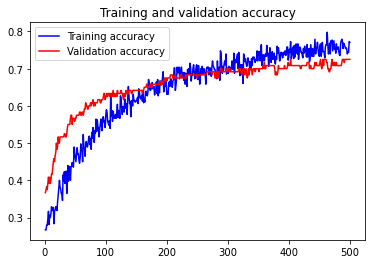

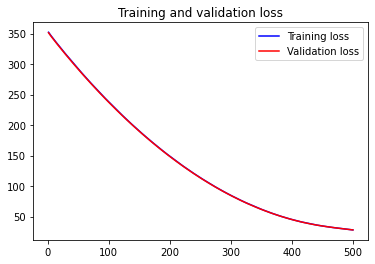

In [288]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [9]:
# Fully connected classifier block USING SGD - THIS IS CURRENT MODEL ON PA
modelFC = keras.Sequential()
modelFC.add(keras.layers.Flatten(input_shape=x_data.shape[1:]))
modelFC.add(keras.layers.Dense(256, activation = 'relu', kernel_regularizer='l2'))
modelFC.add(keras.layers.Dropout(0.5))
modelFC.add(keras.layers.Dense(4,activation = 'softmax'))

optim = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
modelFC.compile(loss="SparseCategoricalCrossentropy",
                optimizer=optim,
                metrics=['accuracy'])

history = modelFC.fit(x_data, 
                      x_labels, 
                      epochs=600, 
                      batch_size=batchSize,
                      validation_data=(y_data, y_labels))
modelFC.save("vgg16_bottle")

Epoch 1/600
48/48 [==============================] - 1s 5ms/step - loss: 6.6412 - accuracy: 0.2792 - val_loss: 6.4409 - val_accuracy: 0.3083
Epoch 2/600
48/48 [==============================] - 0s 3ms/step - loss: 6.6041 - accuracy: 0.3000 - val_loss: 6.3927 - val_accuracy: 0.3167
Epoch 3/600
48/48 [==============================] - 0s 3ms/step - loss: 6.5849 - accuracy: 0.2979 - val_loss: 6.3623 - val_accuracy: 0.3417
Epoch 4/600
48/48 [==============================] - 0s 3ms/step - loss: 6.6081 - accuracy: 0.2646 - val_loss: 6.3443 - val_accuracy: 0.3417
Epoch 5/600
48/48 [==============================] - 0s 3ms/step - loss: 6.4631 - accuracy: 0.3396 - val_loss: 6.3338 - val_accuracy: 0.3500
Epoch 6/600
48/48 [==============================] - 0s 3ms/step - loss: 6.4979 - accuracy: 0.3000 - val_loss: 6.3241 - val_accuracy: 0.3833
Epoch 7/600
48/48 [==============================] - 0s 3ms/step - loss: 6.5194 - accuracy: 0.3042 - val_loss: 6.3177 - val_accuracy: 0.3833
Epoch 8/600
4

Epoch 59/600
48/48 [==============================] - 0s 3ms/step - loss: 6.2471 - accuracy: 0.4646 - val_loss: 6.1695 - val_accuracy: 0.6167
Epoch 60/600
48/48 [==============================] - 0s 3ms/step - loss: 6.2265 - accuracy: 0.4583 - val_loss: 6.1672 - val_accuracy: 0.6167
Epoch 61/600
48/48 [==============================] - 0s 3ms/step - loss: 6.2304 - accuracy: 0.4729 - val_loss: 6.1649 - val_accuracy: 0.6417
Epoch 62/600
48/48 [==============================] - 0s 3ms/step - loss: 6.2501 - accuracy: 0.4146 - val_loss: 6.1628 - val_accuracy: 0.6417
Epoch 63/600
48/48 [==============================] - 0s 3ms/step - loss: 6.2563 - accuracy: 0.4229 - val_loss: 6.1607 - val_accuracy: 0.6417
Epoch 64/600
48/48 [==============================] - 0s 3ms/step - loss: 6.2172 - accuracy: 0.4771 - val_loss: 6.1588 - val_accuracy: 0.6333
Epoch 65/600
48/48 [==============================] - 0s 3ms/step - loss: 6.2308 - accuracy: 0.4563 - val_loss: 6.1571 - val_accuracy: 0.6333
Epoch 

48/48 [==============================] - 0s 3ms/step - loss: 6.0805 - accuracy: 0.5583 - val_loss: 6.0693 - val_accuracy: 0.6833
Epoch 117/600
48/48 [==============================] - 0s 3ms/step - loss: 6.1224 - accuracy: 0.5271 - val_loss: 6.0679 - val_accuracy: 0.6917
Epoch 118/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0854 - accuracy: 0.5646 - val_loss: 6.0664 - val_accuracy: 0.6917
Epoch 119/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0845 - accuracy: 0.5667 - val_loss: 6.0650 - val_accuracy: 0.6667
Epoch 120/600
48/48 [==============================] - 0s 3ms/step - loss: 6.1038 - accuracy: 0.5333 - val_loss: 6.0635 - val_accuracy: 0.6750
Epoch 121/600
48/48 [==============================] - 0s 3ms/step - loss: 6.1127 - accuracy: 0.5625 - val_loss: 6.0619 - val_accuracy: 0.6667
Epoch 122/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0853 - accuracy: 0.5813 - val_loss: 6.0606 - val_accuracy: 0.6667
Epoch 123/600

48/48 [==============================] - 0s 3ms/step - loss: 6.0417 - accuracy: 0.5917 - val_loss: 5.9997 - val_accuracy: 0.6917
Epoch 174/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0227 - accuracy: 0.6146 - val_loss: 5.9984 - val_accuracy: 0.7000
Epoch 175/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0137 - accuracy: 0.6229 - val_loss: 5.9974 - val_accuracy: 0.7000
Epoch 176/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0296 - accuracy: 0.5792 - val_loss: 5.9962 - val_accuracy: 0.7000
Epoch 177/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0278 - accuracy: 0.5979 - val_loss: 5.9951 - val_accuracy: 0.7000
Epoch 178/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0474 - accuracy: 0.5813 - val_loss: 5.9943 - val_accuracy: 0.7000
Epoch 179/600
48/48 [==============================] - 0s 3ms/step - loss: 6.0502 - accuracy: 0.6125 - val_loss: 5.9933 - val_accuracy: 0.7000
Epoch 180/600

48/48 [==============================] - 0s 3ms/step - loss: 5.9613 - accuracy: 0.6229 - val_loss: 5.9483 - val_accuracy: 0.7167
Epoch 231/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9457 - accuracy: 0.6667 - val_loss: 5.9475 - val_accuracy: 0.7083
Epoch 232/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9568 - accuracy: 0.6500 - val_loss: 5.9467 - val_accuracy: 0.7167
Epoch 233/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9681 - accuracy: 0.6187 - val_loss: 5.9458 - val_accuracy: 0.7083
Epoch 234/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9917 - accuracy: 0.6104 - val_loss: 5.9452 - val_accuracy: 0.7083
Epoch 235/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9513 - accuracy: 0.6313 - val_loss: 5.9442 - val_accuracy: 0.7083
Epoch 236/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9433 - accuracy: 0.6500 - val_loss: 5.9432 - val_accuracy: 0.7083
Epoch 237/600

48/48 [==============================] - 0s 3ms/step - loss: 5.9114 - accuracy: 0.6750 - val_loss: 5.9053 - val_accuracy: 0.7167
Epoch 288/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9148 - accuracy: 0.6667 - val_loss: 5.9051 - val_accuracy: 0.7167
Epoch 289/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9219 - accuracy: 0.6375 - val_loss: 5.9045 - val_accuracy: 0.7083
Epoch 290/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9169 - accuracy: 0.6604 - val_loss: 5.9041 - val_accuracy: 0.7250
Epoch 291/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9088 - accuracy: 0.6812 - val_loss: 5.9032 - val_accuracy: 0.7083
Epoch 292/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9253 - accuracy: 0.6438 - val_loss: 5.9027 - val_accuracy: 0.7083
Epoch 293/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9114 - accuracy: 0.6583 - val_loss: 5.9018 - val_accuracy: 0.7167
Epoch 294/600

48/48 [==============================] - 0s 3ms/step - loss: 5.8617 - accuracy: 0.6771 - val_loss: 5.8702 - val_accuracy: 0.7333
Epoch 345/600
48/48 [==============================] - 0s 3ms/step - loss: 5.9013 - accuracy: 0.6562 - val_loss: 5.8700 - val_accuracy: 0.7417
Epoch 346/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8808 - accuracy: 0.6750 - val_loss: 5.8693 - val_accuracy: 0.7333
Epoch 347/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8680 - accuracy: 0.6750 - val_loss: 5.8686 - val_accuracy: 0.7250
Epoch 348/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8606 - accuracy: 0.6812 - val_loss: 5.8678 - val_accuracy: 0.7333
Epoch 349/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8805 - accuracy: 0.6812 - val_loss: 5.8674 - val_accuracy: 0.7333
Epoch 350/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8675 - accuracy: 0.6687 - val_loss: 5.8668 - val_accuracy: 0.7333
Epoch 351/600

48/48 [==============================] - 0s 3ms/step - loss: 5.8082 - accuracy: 0.7312 - val_loss: 5.8395 - val_accuracy: 0.7250
Epoch 402/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8281 - accuracy: 0.7021 - val_loss: 5.8388 - val_accuracy: 0.7250
Epoch 403/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8005 - accuracy: 0.7104 - val_loss: 5.8382 - val_accuracy: 0.7167
Epoch 404/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8181 - accuracy: 0.6917 - val_loss: 5.8376 - val_accuracy: 0.7167
Epoch 405/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8442 - accuracy: 0.7000 - val_loss: 5.8373 - val_accuracy: 0.7250
Epoch 406/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8319 - accuracy: 0.7042 - val_loss: 5.8369 - val_accuracy: 0.7250
Epoch 407/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8405 - accuracy: 0.7042 - val_loss: 5.8366 - val_accuracy: 0.7250
Epoch 408/600

48/48 [==============================] - 0s 3ms/step - loss: 5.8055 - accuracy: 0.7083 - val_loss: 5.8120 - val_accuracy: 0.7250
Epoch 459/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7885 - accuracy: 0.7042 - val_loss: 5.8115 - val_accuracy: 0.7250
Epoch 460/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7932 - accuracy: 0.7021 - val_loss: 5.8107 - val_accuracy: 0.7167
Epoch 461/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8030 - accuracy: 0.6958 - val_loss: 5.8106 - val_accuracy: 0.7333
Epoch 462/600
48/48 [==============================] - 0s 3ms/step - loss: 5.8163 - accuracy: 0.7063 - val_loss: 5.8104 - val_accuracy: 0.7083
Epoch 463/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7839 - accuracy: 0.7188 - val_loss: 5.8096 - val_accuracy: 0.7083
Epoch 464/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7900 - accuracy: 0.7042 - val_loss: 5.8094 - val_accuracy: 0.7083
Epoch 465/600

48/48 [==============================] - 0s 3ms/step - loss: 5.7443 - accuracy: 0.7292 - val_loss: 5.7864 - val_accuracy: 0.7250
Epoch 516/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7622 - accuracy: 0.7458 - val_loss: 5.7860 - val_accuracy: 0.7167
Epoch 517/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7651 - accuracy: 0.7250 - val_loss: 5.7857 - val_accuracy: 0.7167
Epoch 518/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7461 - accuracy: 0.7229 - val_loss: 5.7855 - val_accuracy: 0.7167
Epoch 519/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7464 - accuracy: 0.7354 - val_loss: 5.7849 - val_accuracy: 0.7167
Epoch 520/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7503 - accuracy: 0.7229 - val_loss: 5.7842 - val_accuracy: 0.7167
Epoch 521/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7556 - accuracy: 0.7375 - val_loss: 5.7838 - val_accuracy: 0.7167
Epoch 522/600

48/48 [==============================] - 0s 3ms/step - loss: 5.7458 - accuracy: 0.7396 - val_loss: 5.7656 - val_accuracy: 0.7167
Epoch 573/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7321 - accuracy: 0.7333 - val_loss: 5.7652 - val_accuracy: 0.7250
Epoch 574/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7405 - accuracy: 0.7354 - val_loss: 5.7646 - val_accuracy: 0.7167
Epoch 575/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7297 - accuracy: 0.7312 - val_loss: 5.7642 - val_accuracy: 0.7167
Epoch 576/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7273 - accuracy: 0.7500 - val_loss: 5.7636 - val_accuracy: 0.7250
Epoch 577/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7301 - accuracy: 0.7333 - val_loss: 5.7634 - val_accuracy: 0.7167
Epoch 578/600
48/48 [==============================] - 0s 3ms/step - loss: 5.7651 - accuracy: 0.7104 - val_loss: 5.7629 - val_accuracy: 0.7167
Epoch 579/600

2022-04-05 22:13:58.800775: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: bottleneckmodel/assets


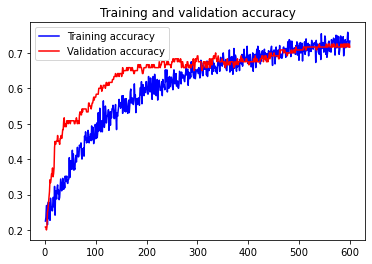

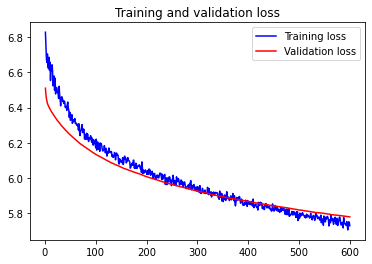

In [290]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [28]:
rebuilt_model = keras.models.load_model("bottleneckmodel")
img = cv2.resize(cv2.imread(r'/home/nicholas/notebook/jupyterenv/spiderid/initial_model/bespokenew/tigrosa/annexa (5).jpeg', cv2.IMREAD_COLOR), (160, 160), interpolation=cv2.INTER_CUBIC)
img_arr = tf.keras.utils.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

# Two stage prediction - feed into stock VGG16 base, then pass to fully connected model
features = modelVGG16.predict(img_arr)
print(np.argmax(rebuilt_model.predict(features))) # 0: araneus, 1: latrodectus, 2: pisaurina, 3: tigrosa

3
